In [ ]:
!pip3 install "tqdm"

In [ ]:
import sys
import copy
import torch
import torch.nn as nn
from torch.backends import cudnn
from torch.autograd import Variable
import datetime
from pytz import timezone
import os
import math
import time
from torchvision.datasets import CIFAR100
from torchvision.transforms import transforms
import torchvision.utils
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sn
import torch.nn.functional as F

In [ ]:
if not os.path.isdir('./OpenWorld'):
  !git clone https://github.com/Alessia-Sc/Open-World-Recognition.git OpenWorld

from OpenWorld.CIFAR100 import DatasetCifar100
from OpenWorld.ResNet import resnet32
from tqdm.notebook import tqdm


Cloning into 'OpenWorld'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 147 (delta 86), reused 19 (delta 10), pack-reused 0
Receiving objects: 100% (147/147), 36.63 KiB | 12.21 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [ ]:
DEVICE = 'cuda'
NUM_CLASSES = 100
N_GROUPS_FOR_TRAINING = 10  # Number of grups

BATCH_SIZE = 128
LR = 2.                    
MOMENTUM = 0.9              # Hyperparameter for SGD
WEIGHT_DECAY = 1e-5         # Regularization

NUM_EPOCHS = 70           
GAMMA = 0.2                 # Multiplicative factor for learning rate step-down
MILESTONE=[49, 63]

In [ ]:
#LOAD DATASET
train_ds = DatasetCifar100(split="train", rand_seed=None) 
test_ds = DatasetCifar100(split="test", rand_seed=None)

print(f"\nLen Train Dataset: {len(train_ds.dataset.targets)},  Len Test Dataset: {len(test_ds.dataset.targets)}")
shuffled_classes = train_ds.classes
print("\nClasses in each group of 10:")
for i in range(10):
  print(f"\tGROUP {i+1}°: {shuffled_classes[i*10:(i*10)+10]}")


Extracting ./CIFAR_100/cifar-100-python.tar.gz to ./CIFAR_100
Files already downloaded and verified

Len Train Dataset: 50000,  Len Test Dataset: 10000

Classes in each group of 10:
	GROUP 1°: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52]
	GROUP 2°: [47, 87, 1, 41, 93, 6, 88, 12, 38, 91]
	GROUP 3°: [81, 33, 8, 48, 60, 27, 50, 17, 56, 97]
	GROUP 4°: [34, 42, 84, 66, 62, 26, 29, 51, 3, 72]
	GROUP 5°: [39, 9, 37, 85, 13, 25, 11, 67, 99, 74]
	GROUP 6°: [30, 2, 64, 71, 19, 35, 31, 63, 54, 15]
	GROUP 7°: [43, 73, 40, 55, 7, 78, 14, 10, 70, 44]
	GROUP 8°: [0, 86, 79, 57, 75, 46, 83, 82, 22, 4]
	GROUP 9°: [45, 18, 89, 5, 59, 21, 95, 96, 69, 16]
	GROUP 10°: [98, 23, 80, 65, 76, 77, 20, 24, 94, 53]


In [ ]:
n_known=0
n_classes=0
accuracies_test = []
net = resnet32(num_classes=NUM_CLASSES)
criterion = nn.BCEWithLogitsLoss() 

for group in range(N_GROUPS_FOR_TRAINING):
  print("\n")
  print('-' * 80)
  print(f"ITERATION: {(group+1)*10}/100")

  n_classes+=10
  current_classes = shuffled_classes[(group)*10:(group+1)*10]
  print(f'\nCurrent classes: {current_classes}')
 
  #COMPUTE INDEXES OF IMAGES
  new_indexes = train_ds.get_indexes_from_labels(current_classes)
  train_ds_curr = Subset(train_ds, new_indexes)   #Subset of training images

  cumulative_classes=shuffled_classes[0:(group+1)*10]
  print(f'Cumulative classes: {cumulative_classes}')

  test_indexes = test_ds.get_indexes_from_labels(cumulative_classes) #Cumulative classes for the test set
  test_ds_cum = Subset(test_ds, test_indexes)
  
  #Get Dataloader
  train_dataloader = DataLoader(train_ds_curr, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
  test_dataloader = DataLoader(test_ds_cum, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)

  print("Batch size train: {} - Batch size test: {}".format(len(train_ds_curr), len(test_ds_cum)))

  net = net.to(DEVICE)
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONE, gamma=GAMMA)

  losses_train = []
  accuracies_train = []
  net_old = None
  
  if n_known > 0:
    net_old = copy.deepcopy(net)  #SAVE OLD MODEL

  for epoch in tqdm(range(NUM_EPOCHS)):
    losses = []
    running_loss_train = 0.0
    running_corrects_train = 0

    net.train()
    for idx, images, labels in train_dataloader: 
      labels = torch.tensor([torch.tensor(train_ds.dict_class_label[c.item()]) for c in labels])  #Mapping labels in order to obtain the idx
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      optimizer.zero_grad() # Zero-ing the gradients 
      with torch.set_grad_enabled(True):
        logits = net.forward(images)

        #ONE HOT
        targets_bce = F.one_hot(labels, n_classes).float().cuda()
        if n_known>0:
          dist_target = net_old.forward(images).cuda()
          dist_target = torch.sigmoid(dist_target).cuda()    
          target = torch.cat((dist_target[:,:n_known], targets_bce[:,n_known:n_classes]), dim=1)
          loss = criterion(logits[:,:n_classes], target)
        else:
          loss = criterion(logits[:,:n_classes], targets_bce[:,:n_classes])

        loss.backward()       #Backward pass: computes gradients 
        optimizer.step()      #Update weights based on accumulated gradients 
    
    #END OF CURRENT EPOCH
    scheduler.step()

  n_known+=10

  #Compute accuracy on test 
  total = 0.0 
  correct = 0.0
  net.train(False)
  running_loss = 0.0
  running_corrects = 0
  y_true = []
  y_pred = []
  
  for idx, images_test, labels_test in test_dataloader:
    labels_test = torch.tensor([torch.tensor(train_ds.dict_class_label[c.item()]) for c in labels_test])
    images_test = images_test.to(DEVICE)
    labels_test = labels_test.to(DEVICE)

    with torch.set_grad_enabled(False):
      outputs_test = net.forward(images_test) # Forward Pass
      _, preds = torch.max(torch.softmax(outputs_test, dim=1), dim=1, keepdim=False) # Get predictions

    total = total + len(labels_test)
    correct += (preds.data.cpu() == labels_test.cpu()).sum()
    
    labels = labels_test.detach().cpu().numpy()
    labels = labels.tolist()
    y_true.extend(labels)
    preds = preds.detach().cpu().numpy()
    y_pred_tmp = [p for p in preds]
    y_pred.extend(y_pred_tmp)

  acc = 100 * correct / total
  print('ACC ON TEST: {} %'.format(acc))
      
  accuracies_test.append(acc)



--------------------------------------------------------------------------------
ITERATION: 10/100

Current classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52]
Batch size train: 5000 - Batch size test: 1000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



ACC ON TEST: 83.5 %


--------------------------------------------------------------------------------
ITERATION: 20/100

Current classes: [47, 87, 1, 41, 93, 6, 88, 12, 38, 91]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91]
Batch size train: 5000 - Batch size test: 2000



ACC ON TEST: 63.20000076293945 %


--------------------------------------------------------------------------------
ITERATION: 30/100

Current classes: [81, 33, 8, 48, 60, 27, 50, 17, 56, 97]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97]
Batch size train: 5000 - Batch size test: 3000



ACC ON TEST: 56.70000076293945 %


--------------------------------------------------------------------------------
ITERATION: 40/100

Current classes: [34, 42, 84, 66, 62, 26, 29, 51, 3, 72]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97, 34, 42, 84, 66, 62, 26, 29, 51, 3, 72]
Batch size train: 5000 - Batch size test: 4000



ACC ON TEST: 46.900001525878906 %


--------------------------------------------------------------------------------
ITERATION: 50/100

Current classes: [39, 9, 37, 85, 13, 25, 11, 67, 99, 74]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97, 34, 42, 84, 66, 62, 26, 29, 51, 3, 72, 39, 9, 37, 85, 13, 25, 11, 67, 99, 74]
Batch size train: 5000 - Batch size test: 5000



ACC ON TEST: 42.02000045776367 %


--------------------------------------------------------------------------------
ITERATION: 60/100

Current classes: [30, 2, 64, 71, 19, 35, 31, 63, 54, 15]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97, 34, 42, 84, 66, 62, 26, 29, 51, 3, 72, 39, 9, 37, 85, 13, 25, 11, 67, 99, 74, 30, 2, 64, 71, 19, 35, 31, 63, 54, 15]
Batch size train: 5000 - Batch size test: 6000



ACC ON TEST: 34.25 %


--------------------------------------------------------------------------------
ITERATION: 70/100

Current classes: [43, 73, 40, 55, 7, 78, 14, 10, 70, 44]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97, 34, 42, 84, 66, 62, 26, 29, 51, 3, 72, 39, 9, 37, 85, 13, 25, 11, 67, 99, 74, 30, 2, 64, 71, 19, 35, 31, 63, 54, 15, 43, 73, 40, 55, 7, 78, 14, 10, 70, 44]
Batch size train: 5000 - Batch size test: 7000



ACC ON TEST: 28.64285659790039 %


--------------------------------------------------------------------------------
ITERATION: 80/100

Current classes: [0, 86, 79, 57, 75, 46, 83, 82, 22, 4]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97, 34, 42, 84, 66, 62, 26, 29, 51, 3, 72, 39, 9, 37, 85, 13, 25, 11, 67, 99, 74, 30, 2, 64, 71, 19, 35, 31, 63, 54, 15, 43, 73, 40, 55, 7, 78, 14, 10, 70, 44, 0, 86, 79, 57, 75, 46, 83, 82, 22, 4]
Batch size train: 5000 - Batch size test: 8000



ACC ON TEST: 27.837499618530273 %


--------------------------------------------------------------------------------
ITERATION: 90/100

Current classes: [45, 18, 89, 5, 59, 21, 95, 96, 69, 16]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97, 34, 42, 84, 66, 62, 26, 29, 51, 3, 72, 39, 9, 37, 85, 13, 25, 11, 67, 99, 74, 30, 2, 64, 71, 19, 35, 31, 63, 54, 15, 43, 73, 40, 55, 7, 78, 14, 10, 70, 44, 0, 86, 79, 57, 75, 46, 83, 82, 22, 4, 45, 18, 89, 5, 59, 21, 95, 96, 69, 16]
Batch size train: 5000 - Batch size test: 9000



ACC ON TEST: 25.5 %


--------------------------------------------------------------------------------
ITERATION: 100/100

Current classes: [98, 23, 80, 65, 76, 77, 20, 24, 94, 53]
Cumulative classes: [36, 61, 49, 58, 92, 90, 68, 32, 28, 52, 47, 87, 1, 41, 93, 6, 88, 12, 38, 91, 81, 33, 8, 48, 60, 27, 50, 17, 56, 97, 34, 42, 84, 66, 62, 26, 29, 51, 3, 72, 39, 9, 37, 85, 13, 25, 11, 67, 99, 74, 30, 2, 64, 71, 19, 35, 31, 63, 54, 15, 43, 73, 40, 55, 7, 78, 14, 10, 70, 44, 0, 86, 79, 57, 75, 46, 83, 82, 22, 4, 45, 18, 89, 5, 59, 21, 95, 96, 69, 16, 98, 23, 80, 65, 76, 77, 20, 24, 94, 53]
Batch size train: 5000 - Batch size test: 10000



ACC ON TEST: 23.8799991607666 %


In [ ]:
diz=test_ds.dict_class_label #quindi abbiamo il dizionario {classe: indice} = {56:0}, {99,1},.. x tutte le 100 classi
y_t=[]
y_p=[]
for el1,el2 in zip(y_true,y_pred):
  y_t.append(diz[el1]) # se le prime immagini sono un 56, un 56 e un 99 avrò [0,0,1]
  y_p.append(diz[el2]) # mentre magari le predette sono 56, 33, 99 [0,3,1]
print(y_pred)

[90, 68, 58, 26, 92, 96, 34, 50, 20, 90, 83, 91, 99, 32, 31, 93, 95, 89, 79, 49, 62, 75, 91, 94, 95, 62, 20, 75, 79, 92, 90, 18, 62, 90, 18, 74, 81, 59, 67, 25, 95, 82, 83, 80, 95, 20, 36, 91, 50, 71, 93, 84, 58, 93, 67, 93, 42, 98, 50, 99, 20, 80, 81, 26, 82, 96, 93, 81, 90, 88, 93, 79, 43, 78, 52, 35, 81, 80, 99, 57, 79, 93, 97, 67, 96, 32, 26, 53, 94, 29, 17, 95, 79, 81, 91, 92, 99, 26, 26, 72, 86, 97, 25, 92, 90, 50, 85, 99, 25, 26, 82, 99, 84, 99, 93, 26, 80, 79, 86, 92, 81, 20, 43, 25, 92, 93, 97, 97, 94, 54, 90, 51, 79, 63, 87, 79, 79, 95, 91, 81, 78, 19, 95, 17, 21, 94, 81, 90, 50, 91, 20, 26, 13, 92, 95, 90, 72, 93, 81, 99, 97, 90, 94, 94, 79, 94, 90, 91, 20, 83, 76, 23, 99, 91, 36, 85, 90, 26, 5, 79, 91, 81, 88, 93, 68, 26, 87, 93, 92, 96, 0, 13, 85, 50, 96, 50, 73, 67, 95, 16, 53, 68, 92, 26, 89, 92, 92, 92, 97, 93, 92, 85, 90, 92, 63, 62, 50, 84, 83, 62, 83, 79, 93, 93, 0, 79, 19, 26, 26, 90, 81, 62, 80, 82, 93, 92, 99, 18, 92, 25, 86, 96, 99, 86, 92, 82, 50, 81, 18, 84, 34

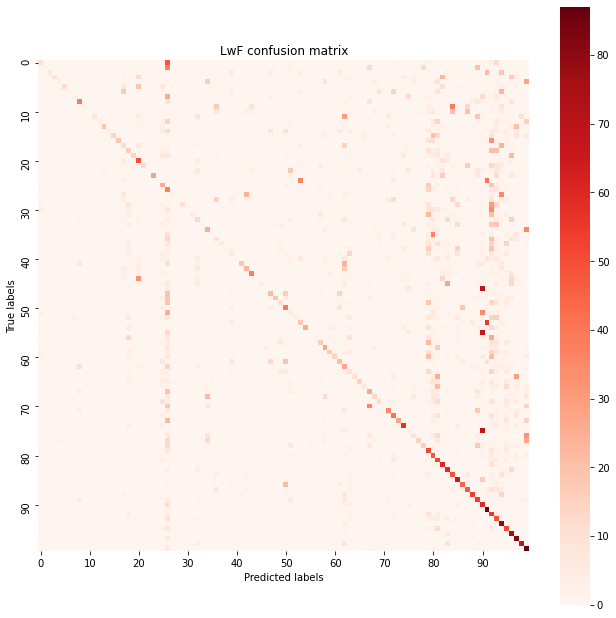

In [ ]:
# Compute and display confusion matrix
acc_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(11,11))
df_cm = pd.DataFrame(acc_matrix)
sn.heatmap(df_cm, square=True, xticklabels=10, yticklabels=10, cmap='Reds')
plt.title("LwF confusion matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()